In [1]:
import numpy as np
import matplotlib.pyplot as plt
from discminer.mining_utils import get_noise_mask, init_data_and_model
from fforge.inference.emulator import Emulator
from fforge.utils.utils import vr_norm, vaz_norm, generate_ict_128x128_disc_tri_slopes, nullv
import fforge.utils.units as u

In [2]:
#right now the integration works only after discminer has been rone on the data to fit the 
#underlying basic model. That sets, for example, the profile of the emission layers, the disk extent, ...

#for the moment, let's use the example in discminer package MWC480

In [3]:
datacube, model = init_data_and_model(
        Rmin=0,
        Rmax=1,
        parfile='parfile.json',
    )

     _  _                        _                    
  __| |(_) ___   ___  _ __ ___  (_) _ __    ___  _ __ 
 / _` || |/ __| / __|| '_ ` _ \ | || '_ \  / _ \| '__|
| (_| || |\__ \| (__ | | | | | || || | | ||  __/| |   
 \__,_||_||___/ \___||_| |_| |_||_||_| |_| \___||_|   
                                                      

*====================================================================================================*
Computing grid...
Grid maximum extent: 120689578165943.16
Grid step (cell size): 969394202136.0896
*====================================================================================================*
*====================================================================================================*
Computing grid...
Grid maximum extent: 107118059336037.9
Grid step (cell size): 969394202136.0896
*====================================================================================================*
Setting beam_info var to Beam: BMAJ=0.165413767099392 arcsec

In [4]:
#setup emulator
#setup emulator
labels = ["vphi", "vr"]
pths = [
    "/home/aleruzza/UNI/SCIENCE/UnetEmu/trained_models/vphi_256/model__epoch_1980_test_vaz_256.pth",
    "/home/aleruzza/UNI/SCIENCE/UnetEmu/trained_models/vr_256/model__epoch_1980_test_vr_256.pth",
]
params = [
    "/home/aleruzza/UNI/SCIENCE/UnetEmu/trained_models/vphi_256/params.py",
    "/home/aleruzza/UNI/SCIENCE/UnetEmu/trained_models/vr_256/params.py",
]

#functions used to denormalize the emulator output
norm_funcs = [vaz_norm, vr_norm]

emu = Emulator(
    model_pths=pths,
    labels=["vphi", "vr"],
    model_params=params,
    norm_funcs=norm_funcs,
    ict_gen=generate_ict_128x128_disc_tri_slopes,
)

In [17]:
#setup emulator parameters and update emulator velocity function
emu_params = {
        "R_p": 300 * u.au,
        "phi_p": -3*np.pi/4,
        "alpha": 1e-2,
        "h": 0.1,
        "planetMass": 1e-3,
        "flaringIndex": 0.25,
        "extrap_vfunc": nullv
 }
model.velocity_func = emu.emulate_v3d
model.params['velocity'].update(emu_params)    

Setting velocity function to <bound method Emulator.emulate_v3d of <fforge.inference.emulator.Emulator object at 0x14ece65f1570>>


In [55]:
def emulate_v3d(

        coord,
        R_p,
        phi_p,
        **extrap_kwargs,
    ):
        
        phi = np.arctan2(coord['y'], coord['x'])
        R = np.sqrt(coord['x']**2 + coord['y']**2)

        v = (1000.*( (phi>(phi_p-0.1)) & (phi<(phi_p+0.1)))).reshape(1, *phi.shape)
        
        v3d_interp = np.concatenate(
            [
                v.copy(),
                v.copy(),
                v.copy(),
            ],
            axis=0,
        )

        return v3d_interp

In [18]:
%%time
#emulate and generate cmap
modelcube = model.make_model(make_convolve=False)

*====================================================================================================*
Running prototype model with the following parameters:

{'height_lower': {'Rb': 803.90594,
                  'p': 1.107099,
                  'q': 2.859784,
                  'z0': 14.227028},
 'height_upper': {'Rb': 108.607483,
                  'p': 1.65208,
                  'q': 0.550336,
                  'z0': 52.680114},
 'intensity': {'I0': 0.10439999999999999,
               'Rout': 717.971915,
               'p': -2.659016,
               'q': 2.156254},
 'lineslope': {'Ls': 1.676401, 'p': 0.314061},
 'linewidth': {'L0': 0.316459, 'p': -0.288951, 'q': -0.355926},
 'orientation': {'PA': 1.010296,
                 'incl': -0.672928,
                 'xc': -0.91338,
                 'yc': -1.826827},
 'velocity': {'Mstar': 1.973085,
              'R_p': 44879361210000.0,
              'alpha': 0.01,
              'extrap_vfunc': <function nullv at 0x14ece65de7a0>,
             

In [7]:
%matplotlib inline

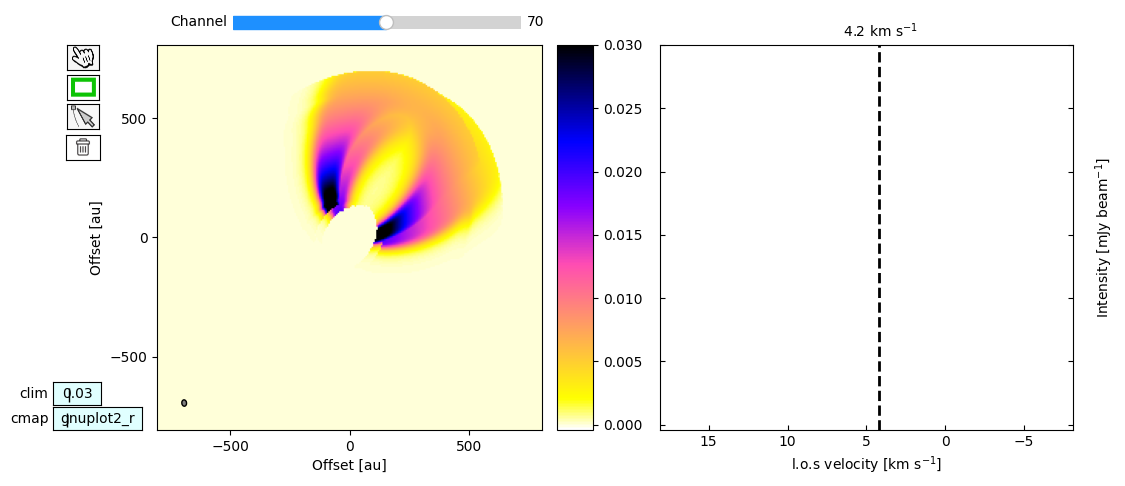

In [8]:
modelcube.show(chan_init=70)

In [9]:
#this creates a gif
modelcube.make_gif()

mkdir: cannot create directory ‘./gif/’: File exists


Making movie...


In [8]:
r = np.load('upper_R.npy')
phi = np.load('upper_phi.npy')

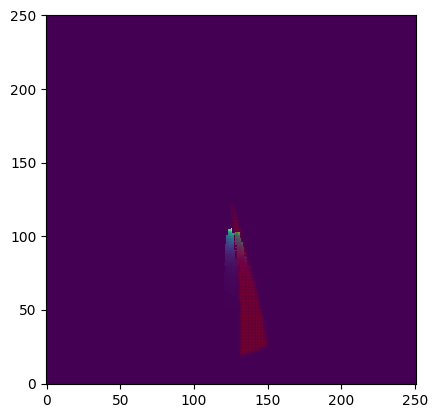

In [24]:
x = y = np.linspace(0,250,250)
xx, yy = np.meshgrid(x, y)
mask = (r<301*u.au) & (r> 299*u.au)
mask_phi = (phi>(-3*np.pi/4-0.1)) & (phi<(-3*np.pi/4+0.1))
plt.pcolormesh(xx, yy, modelcube.data[67], shading='nearest')
plt.scatter(xx[mask_phi], yy[mask_phi], color='red', marker='.', alpha=0.02)
plt.gca().set_aspect('equal')

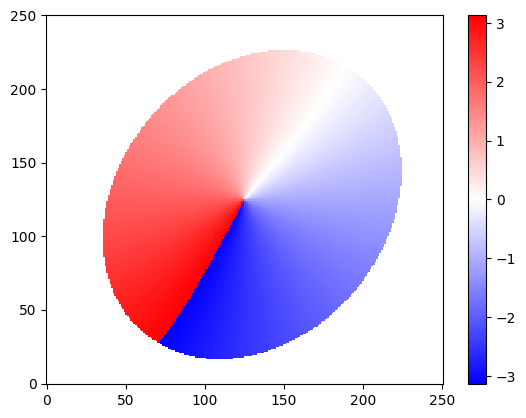

In [28]:
plt.pcolormesh(xx, yy, phi, shading='nearest', cmap='bwr')
plt.colorbar()